In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency 
from scipy import stats
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

# Create dataframe 
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [2]:
# show first five rows to get an overview
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# Desciption of each coloumn
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [4]:
# Attribute overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
# Number of null (missing) values 
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
# Figuring out how many of the strokes that have a missing bmi
stroke_df = df[df['stroke'] == 1]
stroke_df.isnull().sum()

id                    0
gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  40
smoking_status        0
stroke                0
dtype: int64

# Missing values

We want to deal with our missing values before moving on. 

In [7]:
# We drop the id column, since we know we are not going to use it 
df = df.drop('id',1)

In [10]:
# We create a pipeline in order to reuse it later
# We want to use a decisiontree so that we do not need to replace 1/5 of the strokes with the same value of bmi
# by replacing it with mean or median

DecisionTreePip = Pipeline(steps=[ 
                               ('Scale',StandardScaler()),
                               ('DecisionTreeReg',DecisionTreeRegressor(random_state = 42))
                              ])

X = df[['age','gender','bmi']]
X.gender = X.gender.replace({'Male' : 0, 'Female' : 1 , 'Other' : -1}).astype(np.uint8)

# create a dataframe containing the missing values of X
missing = X[X.bmi.isna()]

# remove the missing values from X 
X = X.dropna()

# creates Y by removing bmi from X
Y = X.pop('bmi')

# fit the pipeline
DecisionTreePip.fit(X,Y)

# make the prediction 
predict_bmi = pd.Series(DecisionTreePip.predict(missing[['age', 'gender']]), index = missing.index)
df.loc[missing.index, 'bmi'] = predict_bmi

In [11]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

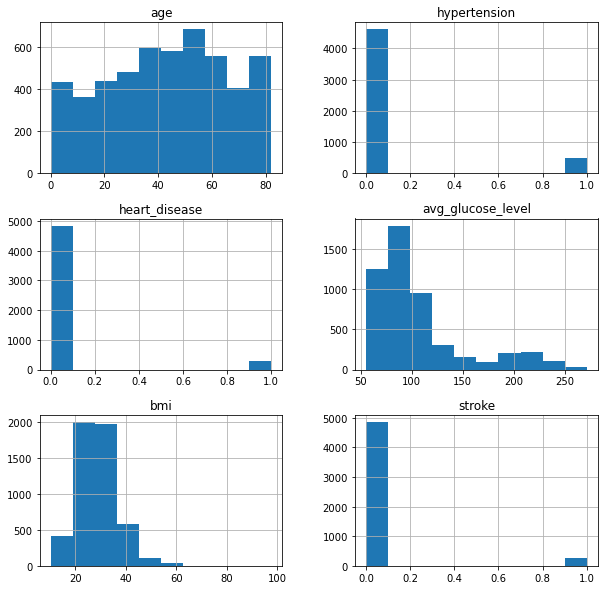

In [10]:
# Histograms
hist = df.hist(figsize = (10,10))

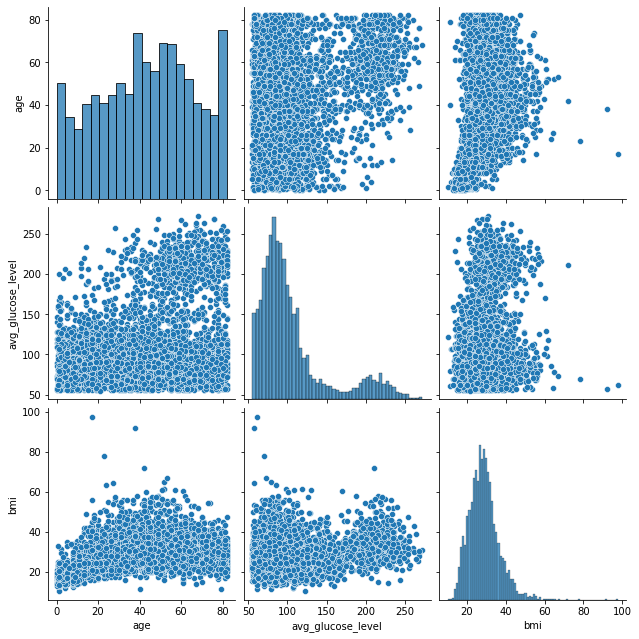

In [11]:
# Pairplots to show where there might be clusters 
sns_plot = sns.pairplot(df, height = 3, vars = ['age','avg_glucose_level', 'bmi'])
        # sns_plot.savefig('pairplot.png') # saves it as a picture 
plt.show()

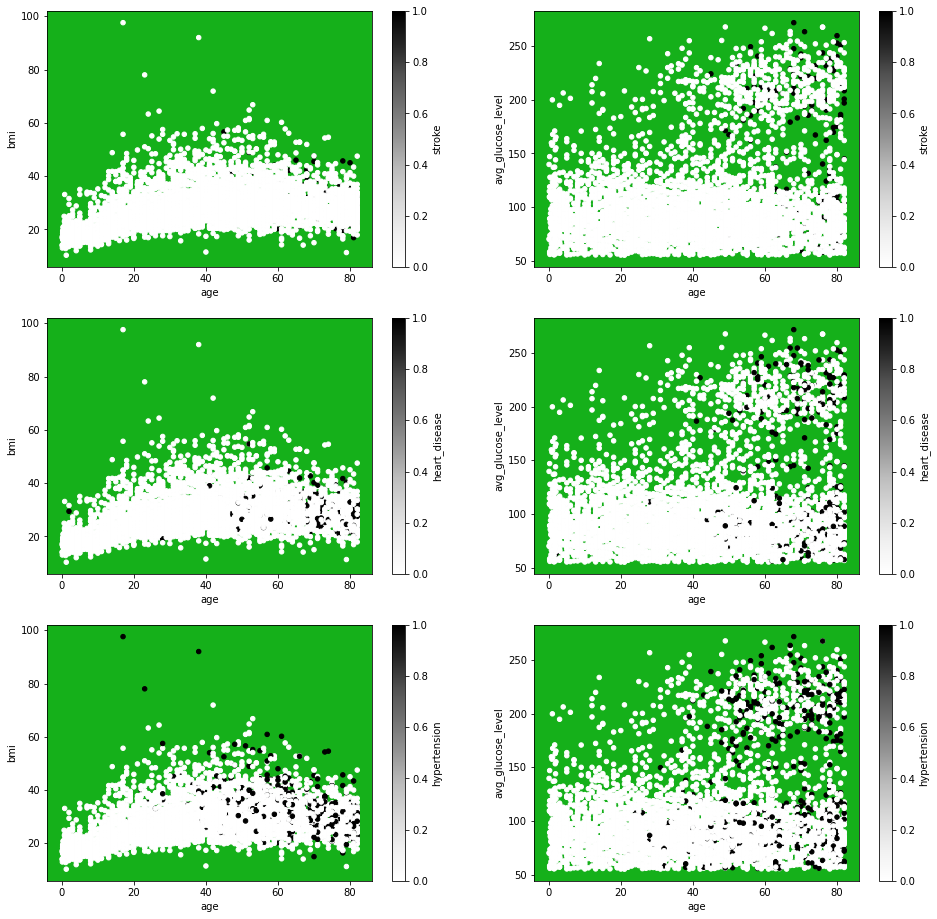

In [9]:
# Scatterplots on two-variable relationships between age(discrete) and continuous variables 
# and binary value (stroke, heart disease and hypertension)

fig, axs = plt.subplots(3,2, figsize=(16,16))

# we added the color because the background was white on our computers 
df.plot.scatter(ax = axs[0,0], x="age", y="bmi", c="stroke").set_facecolor('xkcd:green')
df.plot.scatter(ax = axs[0,1], x="age", y="avg_glucose_level", c="stroke").set_facecolor('xkcd:green')
df.plot.scatter(ax = axs[1,0], x="age", y="bmi", c="heart_disease").set_facecolor('xkcd:green')
df.plot.scatter(ax = axs[1,1], x="age", y="avg_glucose_level", c="heart_disease").set_facecolor('xkcd:green')
df.plot.scatter(ax = axs[2,0], x="age", y="bmi", c="hypertension").set_facecolor('xkcd:green')
df.plot.scatter(ax = axs[2,1], x="age", y="avg_glucose_level", c="hypertension").set_facecolor('xkcd:green')

Overall:
- The higher the age, the more have problems in general (strokes, heart dieseases, hypertension)
- The higher the glucose level, the more seem to have strokes at an higher age!

Strokes:
- High age + high glucose level -> a lot of strokes
- High age but high BMI -> not so many strokes
Heart disease:
- The higher the age, the more heart diseases
- But high BMI does not seem to have a great influence
- Avg glucose level does not seem to matter a lot too
Hypertension
- Also, the higher the age, the more have hypertension, but definitely less clear than for other two
- Interestingly, all outliers with very high BMI have also hypertension
- Avg glucose level really does not influence it much

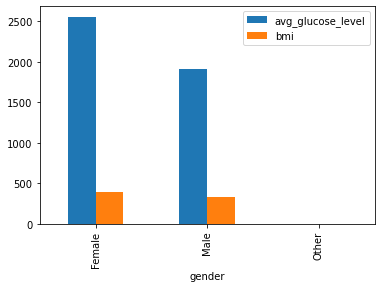

In [10]:
# BMI and glucose level within men and women
df.groupby(['gender']).nunique().plot(kind = 'bar', y = ['avg_glucose_level', 'bmi'])
plt.show()

# Outliers

<AxesSubplot:xlabel='bmi'>

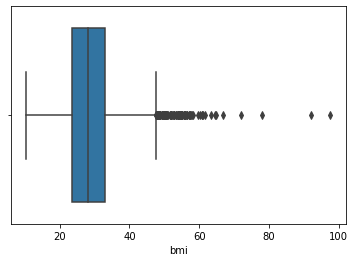

In [11]:
# Outliers in BMI
sns.boxplot(x = df['bmi'])

<AxesSubplot:xlabel='avg_glucose_level'>

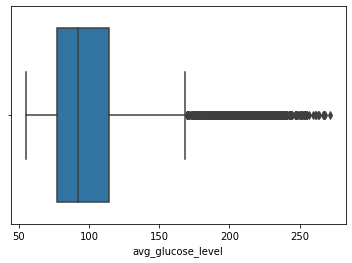

In [12]:
# Outliers on glukose level
sns.boxplot(x = df['avg_glucose_level'])

<AxesSubplot:xlabel='age'>

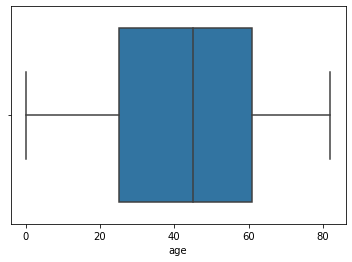

In [13]:
# Outliers on age 
sns.boxplot(x = df['age'])

# Stroke in different groups

In [14]:
# Strokes within men and women 
print((df[df["gender"]=="Male"].sum()["stroke"]/df[df["gender"]=="Male"].count()["stroke"])*100)
print((df[df["gender"]=="Female"].sum()["stroke"]/df[df["gender"]=="Female"].count()["stroke"])*100)

5.106382978723404
4.709418837675351


In [15]:
# Strokes divided between urban and rural
print((df[df["Residence_type"]=="Urban"].sum()["stroke"]/df[df["Residence_type"]=="Urban"].count()["stroke"])*100)
print((df[df["Residence_type"]=="Rural"].sum()["stroke"]/df[df["Residence_type"]=="Rural"].count()["stroke"])*100)

5.200308166409862
4.534606205250596


In [16]:
# Percent of people who have a heartdisease and a stroke, and people who had a stroke but no heart disease 
print((df[df["heart_disease"]==1].sum()["stroke"]/df[df["heart_disease"]==1].count()["stroke"])*100)
print((df[df["heart_disease"]==0].sum()["stroke"]/df[df["heart_disease"]==0].count()["stroke"])*100)

17.02898550724638
4.178733967728589


In [19]:
# Percent of people who have a hypertension and a stroke, and people who had a stroke but no hypertension
print((df[df["hypertension"]==1].sum()["stroke"]/df[df["hypertension"]==1].count()["stroke"])*100)
print((df[df["hypertension"]==0].sum()["stroke"]/df[df["hypertension"]==0].count()["stroke"])*100)

13.253012048192772
3.967909800520382


In [18]:
# Smoking status and stroke
print((df[df["smoking_status"]=="never smoked"].sum()["stroke"]/df[df["smoking_status"]=="never smoked"].count()["stroke"])*100)
print((df[df["smoking_status"]=="Unknown"].sum()["stroke"]/df[df["smoking_status"]=="Unknown"].count()["stroke"])*100)
print((df[df["smoking_status"]=="formerly smoked"].sum()["stroke"]/df[df["smoking_status"]=="formerly smoked"].count()["stroke"])*100)
print((df[df["smoking_status"]=="smokes"].sum()["stroke"]/df[df["smoking_status"]=="smokes"].count()["stroke"])*100)

4.7568710359408035
3.0440414507772022
7.909604519774012
5.323193916349809


# Correlation

"\nWe can't see a strong positive correlation between any numerical value and a stroke\nThe largest positive correlation for a stroke is with age \n"

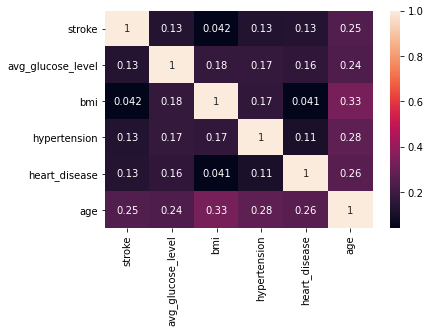

In [39]:
# Correlation heatmap (only between two variables)
# EDIT: Should not use pearson correlation coefficient for binary values (hypertension, heart_disease)...

numerical = df[["stroke", "avg_glucose_level", "bmi", "hypertension", "heart_disease", "age"]]

sns.heatmap(numerical.corr(), annot=True)
'''
We can't see a strong positive correlation between any numerical value and a stroke
The largest positive correlation for a stroke is with age 
'''

# Chi square test

Exploring the relationship between categorical values by using a Chi Square Test

In [43]:
#First look at smoking_status -> stroke!

# Determine significance level
significance_level = 0.05

chisqt = pd.crosstab(df.smoking_status, df.stroke, margins=True)
value = np.array([chisqt.iloc[0][0:5].values,
                  chisqt.iloc[1][0:5].values])
print(chi2_contingency(value)[0:3])
# first value chi-square, second value p-value, then degrees of freedom
if chi2_contingency(value)[1] <= significance_level:
    print("The two varibles have a significant correlation!")
else:
    print("The two varibles have NO significant correlation!")
# chisqt

(29.047623229232553, 4.924801830448134e-07, 2)
The two varibles have a significant correlation!


Now want to determine how much a category value contributes to stroke, therefore we conduct post hoc testing
Conduct multiple 2×2 Chi-square tests using the Bonferroni-adjusted p-value.

In [44]:
# Determine the Bonferroni-adjusted p-value
# The formula is p/N, where “p”= the original tests p-value and “N”= the number of planned pairwise comparisons
bonferroni_p = 0.05/3

dummies = pd.get_dummies(df['smoking_status'])
dummies.drop(["Unknown"], axis= 1, inplace= True)
dummies.head()

,formerly smoked,never smoked,smokes
0,1,0,0
1,0,1,0
2,0,1,0
3,0,0,1
4,0,1,0


In [48]:
# Check whether they are significant and also calculate phi coefficient (like pearson)
# https://www.statisticshowto.com/phi-coefficient-mean-square-contingency-coefficient/ 
# https://en.wikipedia.org/wiki/Phi_coefficient

for series in dummies:
    nl = "\n"
    crosstab = pd.crosstab(dummies[f"{series}"], df['stroke'])
    print(crosstab, nl)
    a = crosstab.loc[0][0] # needed for phi coefficient
    b = crosstab.loc[0][1]
    c = crosstab.loc[1][0]
    d = crosstab.loc[1][1]
    phi_coeff = (a*d-b*c)/sqrt((a+b)*(c+d)*(a+c)*(b+d))
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    significance = p <= bonferroni_p
    print(f"Chi2 value= {chi2}{nl}p-value= {p}{nl}Degrees of freedom= {dof}{nl}Significant {significance}{nl}Phi coefficient {phi_coeff}")
    print()

stroke              0    1
formerly smoked           
0                4046  179
1                 815   70 

Chi2 value= 20.510528545500733
p-value= 5.930414820659066e-06
Degrees of freedom= 1
Significant True
Phi coefficient 0.06455557529819718

stroke           0    1
never smoked           
0             3059  159
1             1802   90 

Chi2 value= 0.05191850370394257
p-value= 0.8197579391268933
Degrees of freedom= 1
Significant False
Phi coefficient -0.004128687879042821

stroke     0    1
smokes           
0       4114  207
1        747   42 

Chi2 value= 0.3015133498043404
p-value= 0.5829352382079063
Degrees of freedom= 1
Significant False
Phi coefficient 0.008939203206269937



Therefore only the category value "formerly smoked" is significant
-> Means that a higher proportion of people who had a stroke also smoked formerly!
-> But VERY low phi coefficient, therefore no true correlation
(Note that correlation does not imply causality. That is, if A and B are correlated, this does not 
 necessarily imply that A causes B or that B causes)

In [49]:
# Next look at work_type -> stroke!
# Determine significance level
significance_level = 0.05

chisqt = pd.crosstab(df.work_type, df.stroke, margins=True)
value = np.array([chisqt.iloc[0][0:5].values,
                  chisqt.iloc[1][0:5].values])
print(chi2_contingency(value)[0:3])
# first value chi-square, second value p-value, then degrees of freedom
if chi2_contingency(value)[1] <= significance_level:
    print("The two varibles have a significant correlation!")
else:
    print("The two varibles have NO significant correlation!")
# chisqt

(1.1614713657633202, 0.5594866104012024, 2)
The two varibles have NO significant correlation!


In [51]:
# Next look at residence type -> stroke!
# Determine significance level
significance_level = 0.05

chisqt = pd.crosstab(df.Residence_type, df.stroke, margins=True)
value = np.array([chisqt.iloc[0][0:5].values,
                  chisqt.iloc[1][0:5].values])
print(chi2_contingency(value)[0:3])
# first value chi-square, second value p-value, then degrees of freedom
if chi2_contingency(value)[1] <= significance_level:
    print("The two varibles have a significant correlation!")
else:
    print("The two varibles have NO significant correlation!")
# chisqt

(1.2210278401168941, 0.5430717019050562, 2)
The two varibles have NO significant correlation!


In [53]:
# Next look at marriage -> stroke!
# Determine significance level
significance_level = 0.05

chisqt = pd.crosstab(df.ever_married, df.stroke, margins=True)
value = np.array([chisqt.iloc[0][0:5].values,
                  chisqt.iloc[1][0:5].values])
print(chi2_contingency(value)[0:3])
# first value chi-square, second value p-value, then degrees of freedom
if chi2_contingency(value)[1] <= significance_level:
    print("The two varibles have a significant correlation!")
else:
    print("The two varibles have NO significant correlation!")
#chisqt

(59.978623069992466, 9.458178026759999e-14, 2)
The two varibles have a significant correlation!


In [55]:
dummies = pd.get_dummies(df['ever_married'])
# dummies.drop(["Unknown"], axis= 1, inplace= True)

In [56]:
# Check whether they are significant and also calculate phi coefficient (like pearson)
# https://www.statisticshowto.com/phi-coefficient-mean-square-contingency-coefficient/ 
# https://en.wikipedia.org/wiki/Phi_coefficient

for series in dummies:
    nl = "\n"
    crosstab = pd.crosstab(dummies[f"{series}"], df['stroke'])
    print(crosstab, nl)
    a = crosstab.loc[0][0] # needed for phi coefficient
    b = crosstab.loc[0][1]
    c = crosstab.loc[1][0]
    d = crosstab.loc[1][1]
    phi_coeff = (a*d-b*c)/sqrt((a+b)*(c+d)*(a+c)*(b+d))
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    significance = p <= bonferroni_p
    print(f"Chi2 value= {chi2}{nl}p-value= {p}{nl}Degrees of freedom= {dof}{nl}Significant {significance}{nl}Phi coefficient {phi_coeff}")
    print()

stroke     0    1
No               
0       3133  220
1       1728   29 

Chi2 value= 58.923890259034195
p-value= 1.6389021142314745e-14
Degrees of freedom= 1
Significant True
Phi coefficient -0.10833974165701027

stroke     0    1
Yes              
0       1728   29
1       3133  220 

Chi2 value= 58.923890259034195
p-value= 1.6389021142314745e-14
Degrees of freedom= 1
Significant True
Phi coefficient 0.10833974165701027



--> The strongest correlation between so far between MARRIED and stroke, with a phi coefficient of 0.10, which is still REALLY low

In [59]:
# numerical

In [ ]:
df_bm